# Modèle simple

# Telechargements & imports des données

In [1]:
# !pip install uv
# !uv pip install pandas gensim numpy matplotlib scikit-learn wordcloud tqdm sentence_transformers ipykernel tensorflow spacy
# !python -m spacy download en_core_web_sm

In [ ]:
import os
import re
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from wordcloud import WordCloud

tqdm.pandas()

import string
import warnings

warnings.filterwarnings("ignore")
import tensorflow as tf
from sentence_transformers import SentenceTransformer

from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
# Telecharger les données
# !wget https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip

--2025-05-21 17:27:12--  https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/AI+Engineer/Project+7%C2%A0-+D%C3%A9tectez+les+Bad+Buzz+gr%C3%A2ce+au+Deep+Learning/sentiment140.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.92.0.192, 52.92.32.72, 52.92.16.192, ...
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.92.0.192|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84855679 (81M) [application/zip]
Saving to: ‘sentiment140.zip.1’

sentiment140.zip.1  100%[===================>]  80.92M  20.5MB/s    in 4.0s    

2025-05-21 17:27:17 (20.5 MB/s) - ‘sentiment140.zip.1’ saved [84855679/84855679]



In [ ]:
# Extraction des données
ZIP_PATH = '/content/sentiment140.zip'

# !unzip $ZIP_PATH

Archive:  /content/sentiment140.zip
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Lecture du Dataframe
DATASET_PATH = '/content/training.1600000.processed.noemoticon.csv'
df = pd.read_csv(DATASET_PATH, sep=',', encoding = "ISO-8859-1", header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Preprocessing des données

## Renommer les colonnes

In [ ]:
# Renommer les colonnes en ce basant sur les cards du dataset
df = df.rename(columns={
    df.columns[0]: 'target',
    df.columns[1]: 'ids',
    df.columns[2]: 'date',
    df.columns[3]: 'flag',
    df.columns[4]: 'user',
    df.columns[5]: 'text',

})

In [ ]:
# Definir les jeux de données

complete_df = df[['target', 'text']]
sample_df = df[['target', 'text']].sample(10_000)

# Afficher la valeurs des labels initiaux
print(sample_df['target'].value_counts())

# Conversion en binaire 0,1
sample_df['target'] = sample_df['target'].replace({0: 0, 4: 1})
complete_df['target'] = complete_df['target'].replace({0: 0, 4: 1})


target
0    5034
4    4966
Name: count, dtype: int64


## Text cleaning

In [ ]:

def tweet_cleaning(tweet):
    """
    Nettoie et prétraite un tweet

    Cette fonction effectue plusieurs étapes de nettoyage :
        - Suppression des URLs, mentions et hashtags
        - Suppression des emojis et caractères spéciaux
        - Suppression de la ponctuation et des chiffres
        - Normalisation du texte (minuscules, espaces multiples)

    Params :
        tweet (str) : Le tweet brut à nettoyer.

    Return :
        str : Le tweet nettoyé et prétraité, prêt pour l'analyse de sentiment.

    """
    # Supprimer les URLs
    tweet = re.sub(r'https?://\S+|www\.\S+', '', tweet)

    # Supprimer les mentions (@user)
    tweet = re.sub(r'@\w+', '', tweet)

    # Supprimer les hashtags (#hashtag)
    tweet = re.sub(r'#\w+', '', tweet)

    # Normaliser & supprimer les caractères
    tweet = tweet.encode('ascii', 'ignore').decode('utf-8')
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)

    # Supprimer la ponctuation
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))

    # Supprimer les chiffres
    tweet = re.sub(r'\d+', '', tweet)

    # Supprimer les espaces multiples et les espaces au début/fin
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    return tweet



In [ ]:
sample_df.apply(lambda x: tweet_cleaning(x['text']), axis=1)

,0
779938,Another linuxless day XP is so bland
940687,back at the barn today to feed the horses and ...
636521,Felt sick earlier this morning so I wasnt able...
568998,I know I was thinking about that yesterday
1053348,and ill be online later when i get back dont t...
...,...
164915,OMG and you have to do this when Im at work an...
1101342,Heroes as in the TV show I mention it a lot on...
1326193,thanks being such a sweetie
524409,owwww arms hurt so much anyone wanna help


## Tokenisation, Lematisation

In [ ]:
import spacy
import nltk
from nltk.stem.snowball import PorterStemmer
nltk.download('punkt')
nltk.download('punkt_tab')


# Charger le modèle anglais
nlp = spacy.load("en_core_web_sm")

# Charger le stemmer anglais
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
def lemmatize_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

In [ ]:
def stem_text_french(text):
    tokens = nltk.word_tokenize(text, language='french')
    return [stemmer.stem(token) for token in tokens]

In [ ]:
def tokenize_text(text):
    doc = nlp(text)
    return [token.text for token in doc]

In [ ]:
text = sample_df['text'].sample(1).values[0]
print(text)

print(lemmatize_text(text=text))
print(stem_text_french(text=text))
print(tokenize_text(text=text))

Yep, conch fritters, ready 2 eat. Lime sauce or cocktail sauce. Way yummy.  http://yfrog.com/59hqnj
['Yep', ',', 'conch', 'fritter', ',', 'ready', '2', 'eat', '.', 'lime', 'sauce', 'or', 'cocktail', 'sauce', '.', 'way', 'yummy', '.', ' ', 'http://yfrog.com/59hqnj']
['yep', ',', 'conch', 'fritter', ',', 'readi', '2', 'eat', '.', 'lime', 'sauc', 'or', 'cocktail', 'sauc', '.', 'way', 'yummi', '.', 'http', ':', '//yfrog.com/59hqnj']
['Yep', ',', 'conch', 'fritters', ',', 'ready', '2', 'eat', '.', 'Lime', 'sauce', 'or', 'cocktail', 'sauce', '.', 'Way', 'yummy', '.', ' ', 'http://yfrog.com/59hqnj']


## Embedding et vectorisation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

from sentence_transformers import SentenceTransformer


In [ ]:
def get_tfidf_vector(texts):
    """
    texts: liste de textes (strings)
    Retourne la matrice TF-IDF et le vecteurur entraîné
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    return vectorizer, tfidf_matrix

In [ ]:
def get_sentence_embeddings(texts, model_name="all-MiniLM-L6-v2"):
    """
    texts: liste de phrases à encoder
    Retourne une liste d'embeddings (vecteurs numpy)
    """
    model = SentenceTransformer(model_name)
    embeddings = model.encode(texts)
    return embeddings

In [ ]:
text = sample_df['text'].sample(1).values[0]
print(text)

print(get_tfidf_vector([text]))
print(get_sentence_embeddings([text]))

## Comparatif global

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def compare_preprocessing_embeddings(df, text_col='text', label_col='target', sample_size=10_000):
    """
    Compare différentes combinaisons de prétraitement + embedding pour la classification.

    Args:
        df (pd.DataFrame): DataFrame contenant les données
        text_col (str): Nom de la colonne texte
        label_col (str): Nom de la colonne cible
        sample_size (int): Taille de l'échantillon à utiliser (pour des raisons de performance)

    Returns:
        None - Affiche un barchart des accuracies
    """
    # Échantillonnage
    df_sample = df.sample(sample_size, random_state=42)
    texts_raw = df_sample[text_col].tolist()
    labels = df_sample[label_col].tolist()

    # Prétraitements
    texts_lemmatized = [' '.join(lemmatize_text(text)) for text in texts_raw]
    texts_tokenized = [' '.join(tokenize_text(text)) for text in texts_raw]
    texts_stemmed = [' '.join(stem_text_french(text)) for text in texts_raw]

    # Dictionnaire des combinaisons à tester
    results = {}

    print("🚀 Début des tests...")

    # --- TF-IDF ---
    print("🔹 TF-IDF")
    vectorizer, X_tfidf = get_tfidf_vector(texts_raw)
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    results["raw_tfidf"] = acc
    print("  - raw + tfidf:", acc)

    vectorizer, X_tfidf = get_tfidf_vector(texts_lemmatized)
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    results["lemmatized_tfidf"] = acc
    print("  - lemma + tfidf:", acc)

    vectorizer, X_tfidf = get_tfidf_vector(texts_tokenized)
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    results["tokenized_tfidf"] = acc
    print("  - token + tfidf:", acc)

    vectorizer, X_tfidf = get_tfidf_vector(texts_stemmed)
    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    results["stemmed_tfidf"] = acc
    print("  - stem + tfidf:", acc)

    # --- Sentence Transformers ---
    print("🔹 Sentence Transformers")

    embeddings = get_sentence_embeddings(texts_raw)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    results["raw_transformer"] = acc
    print("  - raw + transformer:", acc)

    embeddings = get_sentence_embeddings(texts_lemmatized)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    results["lemmatized_transformer"] = acc
    print("  - lemma + transformer:", acc)

    embeddings = get_sentence_embeddings(texts_tokenized)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    results["tokenized_transformer"] = acc
    print("  - token + transformer:", acc)

    embeddings = get_sentence_embeddings(texts_stemmed)
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test))
    results["stemmed_transformer"] = acc
    print("  - stem + transformer:", acc)

    print("\n✅ Fin des tests.")

    # --- Affichage graphique ---
    names = [
        "Raw + TF-IDF",
        "Lemmatization + TF-IDF",
        "Tokenization + TF-IDF",
        "Stemming + TF-IDF",
        "Raw + Transformer",
        "Lemmatization + Transformer",
        "Tokenization + Transformer",
        "Stemming + Transformer"
    ]

    scores = [
        results["raw_tfidf"],
        results["lemmatized_tfidf"],
        results["tokenized_tfidf"],
        results["stemmed_tfidf"],
        results["raw_transformer"],
        results["lemmatized_transformer"],
        results["tokenized_transformer"],
        results["stemmed_transformer"]
    ]

    colors = ['#FF9999' if 'TF-IDF' in name else '#66B2FF' for name in names]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(names, scores, color=colors)
    plt.ylim(0.7, 1.0)
    plt.ylabel("Accuracy")
    plt.title("Comparaison des performances par méthode de prétraitement + embedding")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Ajouter les valeurs au-dessus des barres
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom')

    plt.show()

🚀 Début des tests...
🔹 TF-IDF
  - raw + tfidf: 0.737
  - lemma + tfidf: 0.7455
  - token + tfidf: 0.7405
  - stem + tfidf: 0.742
🔹 Sentence Transformers
  - raw + transformer: 0.7565
  - lemma + transformer: 0.7415
  - token + transformer: 0.7545
  - stem + transformer: 0.7285

✅ Fin des tests.


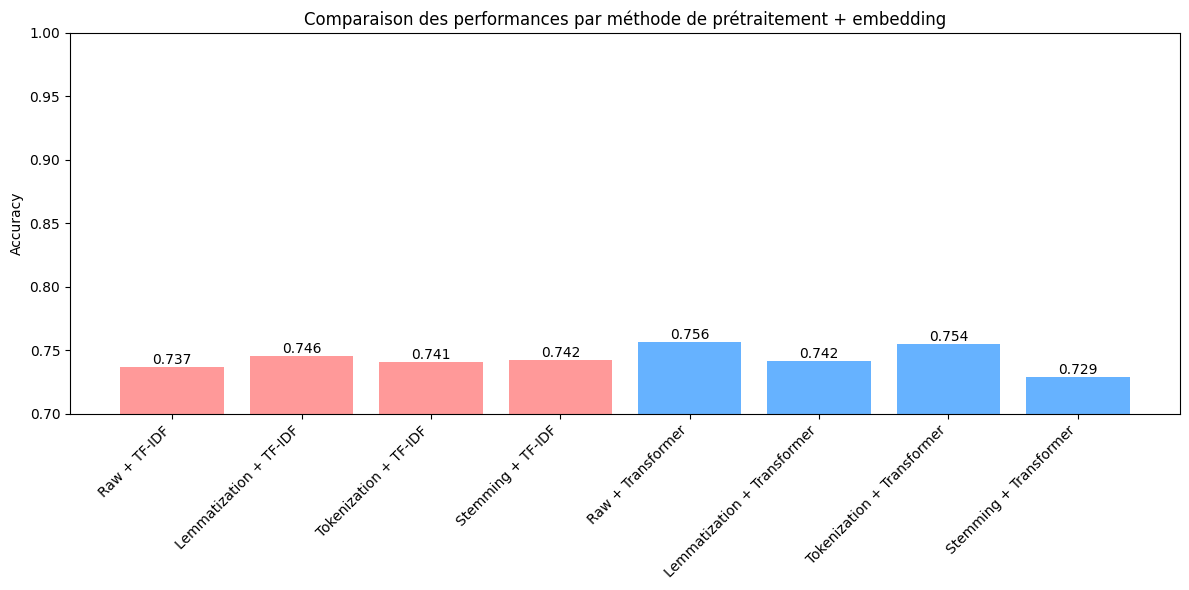

In [29]:
compare_preprocessing_embeddings(complete_df)

# Logger le tout dans MLflow

In [32]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

def compare_preprocessing_embeddings_mlflow(df, text_col='text', label_col='target', sample_size=5000):
    """
    Compare différentes combinaisons de prétraitement + embedding pour la classification.
    Enregistre chaque expérience dans MLflow avec métriques, paramètres et artifacts.

    Args:
        df (pd.DataFrame): DataFrame contenant les données
        text_col (str): Nom de la colonne texte
        label_col (str): Nom de la colonne cible
        sample_size (int): Taille de l'échantillon à utiliser

    Returns:
        None - Affiche un barchart des accuracies et loggue dans MLflow
    """
    # Créer un répertoire pour les matrices de confusion
    os.makedirs("confusion_matrices", exist_ok=True)

    # Échantillonnage
    df_sample = df.sample(sample_size, random_state=42)
    texts_raw = df_sample[text_col].tolist()
    labels = df_sample[label_col].tolist()

    # Prétraitements
    texts_lemmatized = [' '.join(lemmatize_text(text)) for text in texts_raw]
    texts_tokenized = [' '.join(tokenize_text(text)) for text in texts_raw]
    texts_stemmed = [' '.join(stem_text_french(text)) for text in texts_raw]

    # Dictionnaire des combinaisons
    experiments = {
        "raw_tfidf": texts_raw,
        "lemmatized_tfidf": texts_lemmatized,
        "tokenized_tfidf": texts_tokenized,
        "stemmed_tfidf": texts_stemmed,

        "raw_transformer": texts_raw,
        "lemmatized_transformer": texts_lemmatized,
        "tokenized_transformer": texts_tokenized,
        "stemmed_transformer": texts_stemmed,
    }

    # Début de l'expérience MLflow
    mlflow.set_experiment("Text Classification with Logistic Regression")

    print("🚀 Début des tests...")

    for key, texts in experiments.items():
        method = key.split("_")[1]
        preprocessing = key.split("_")[0]
        model_name = f"LogisticRegression_{preprocessing}_{method}"

        print(f"\n🔹 Entraînement : {model_name}")

        # --- Vectorisation ---
        if method == "tfidf":
            vectorizer, X = get_tfidf_vector(texts)
        elif method == "transformer":
            X = get_sentence_embeddings(texts)
        else:
            raise ValueError("Méthode non reconnue")

        # Binariser les étiquettes si nécessaire (pour AUC)
        y = label_binarize(labels, classes=[0, 1])

        # Split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Flatten pour certaines méthodes
        y_train_flat = y_train.ravel()
        y_test_flat = y_test.ravel()

        # --- Entraînement ---
        model = LogisticRegression(max_iter=1000, solver="liblinear", penalty="l2", C=1.0)

        with mlflow.start_run(run_name=model_name):

            # Entraîner
            model.fit(X_train, y_train_flat)

            # Prédire
            y_pred = model.predict(X_test)
            y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0]*len(y_test)

            # Calcul des métriques
            accuracy = accuracy_score(y_test_flat, y_pred)
            f1 = f1_score(y_test_flat, y_pred)
            recall = recall_score(y_test_flat, y_pred)
            precision = precision_score(y_test_flat, y_pred)
            roc_auc = roc_auc_score(y_test_flat, y_proba)
            pr_auc = average_precision_score(y_test_flat, y_proba)

            # Log métriques
            mlflow.log_metrics({
                "accuracy": accuracy,
                "f1": f1,
                "recall": recall,
                "precision": precision,
                "roc_auc": roc_auc,
                "pr_auc": pr_auc
            })

            # Log hyperparamètres
            mlflow.log_params({
                "C": model.C,
                "penalty": model.penalty,
                "solver": model.solver,
                "max_iter": model.max_iter
            })

            # Matrice de confusion
            cm = confusion_matrix(y_test_flat, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm)
            plt.figure(figsize=(4, 4))
            disp.plot(cmap=plt.cm.Blues)
            plt.title(model_name)
            cm_path = f"confusion_matrices/{model_name}.png"
            plt.savefig(cm_path)
            plt.close()

            # Log artifact : matrice de confusion
            mlflow.log_artifact(cm_path)

            # Log dataset en tant que tag (ou partiellement comme artifact)
            mlflow.set_tag("dataset_used", "sentiment140")
            mlflow.set_tag("sample_size", sample_size)
            mlflow.set_tag("preprocessing", preprocessing)
            mlflow.set_tag("embedding_method", method)

            # Log le modèle
            mlflow.sklearn.log_model(model, "model")

            print(f"✅ {model_name} sauvegardé dans MLflow")

    print("\n🎉 Toutes les expériences ont été enregistrées dans MLflow.")

In [39]:
import os

# Vérifie si MLflow tourne déjà (simple check basé sur ps)
status = os.popen("ps aux | grep mlflow").read()
if "mlflow" not in status:
    os.system("mlflow ui --port 11247 &")
    print("MLflow lancé.")
else:
    print("MLflow déjà en cours.")

# Affichage du lien
from google.colab.output import eval_js
print("🔗 MLflow UI :", eval_js("google.colab.kernel.proxyPort(11247)"))

MLflow déjà en cours.
🔗 MLflow UI : https://11247-m-s-1sewvz480i5sj-b.us-central1-0.prod.colab.dev


In [40]:
!ps aux | grep mlflow

root       25979  0.0  0.0   7376  3396 ?        S    18:39   0:00 /bin/bash -c ps aux | grep mlflow
root       25981  0.0  0.0   6484  2336 ?        S    18:39   0:00 grep mlflow


In [37]:
# Lancer la fonction
compare_preprocessing_embeddings_mlflow(sample_df)

2025/05/21 18:33:29 INFO mlflow.tracking.fluent: Experiment with name 'Text Classification with Logistic Regression' does not exist. Creating a new experiment.


🚀 Début des tests...

🔹 Entraînement : LogisticRegression_raw_tfidf


2025/05/21 18:33:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LogisticRegression_raw_tfidf sauvegardé dans MLflow

🔹 Entraînement : LogisticRegression_lemmatized_tfidf


2025/05/21 18:33:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LogisticRegression_lemmatized_tfidf sauvegardé dans MLflow

🔹 Entraînement : LogisticRegression_tokenized_tfidf


2025/05/21 18:33:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LogisticRegression_tokenized_tfidf sauvegardé dans MLflow

🔹 Entraînement : LogisticRegression_stemmed_tfidf


2025/05/21 18:33:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LogisticRegression_stemmed_tfidf sauvegardé dans MLflow

🔹 Entraînement : LogisticRegression_raw_transformer


2025/05/21 18:35:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LogisticRegression_raw_transformer sauvegardé dans MLflow

🔹 Entraînement : LogisticRegression_lemmatized_transformer


2025/05/21 18:36:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LogisticRegression_lemmatized_transformer sauvegardé dans MLflow

🔹 Entraînement : LogisticRegression_tokenized_transformer


2025/05/21 18:37:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LogisticRegression_tokenized_transformer sauvegardé dans MLflow

🔹 Entraînement : LogisticRegression_stemmed_transformer


2025/05/21 18:38:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✅ LogisticRegression_stemmed_transformer sauvegardé dans MLflow

🎉 Toutes les expériences ont été enregistrées dans MLflow.


<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [43]:
def get_mlflow_results_df(experiment_name="Text Classification with Logistic Regression"):
    """
    Récupère tous les runs d'une expérience MLflow et retourne un DataFrame Pandas.

    Args:
        experiment_name (str): Nom de l'expérience MLflow

    Returns:
        pd.DataFrame: DataFrame avec les métriques par run
    """
    # Récupérer l'ID de l'expérience
    experiment = mlflow.get_experiment_by_name(experiment_name)
    if not experiment:
        raise ValueError(f"L'expérience '{experiment_name}' n'existe pas dans MLflow.")

    experiment_id = experiment.experiment_id

    # Récupérer tous les runs de cette expérience
    runs = mlflow.search_runs(experiment_ids=[experiment_id])

    # Colonnes à garder
    columns_to_keep = [
        "tags.mlflow.runName",
        "metrics.accuracy",
        "metrics.f1",
        "metrics.recall",
        "metrics.precision",
        "metrics.roc_auc",
        "metrics.pr_auc"
    ]

    # Renommer les colonnes pour plus de clarté
    df = runs[columns_to_keep].copy()
    df.columns = [
        "Model",
        "Accuracy",
        "F1 Score",
        "Recall",
        "Precision",
        "ROC AUC",
        "PR AUC"
    ]

    # Arrondir les valeurs pour la lisibilité
    numeric_cols = ["Accuracy", "F1 Score", "Recall", "Precision", "ROC AUC", "PR AUC"]
    df[numeric_cols] = df[numeric_cols].round(3)

    return df

In [49]:
# Obtenir le DataFrame
results_df = get_mlflow_results_df()

# Afficher les résultats
# print(results_df)

# Option : afficher sous forme de tableau stylé dans Jupyter/Colab
from IPython.display import display
display(results_df.sort_values(by="Accuracy", ascending=False))

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,PR AUC
4,LogisticRegression_stemmed_tfidf,0.751,0.756,0.764,0.748,0.834,0.837
7,LogisticRegression_raw_tfidf,0.747,0.754,0.770,0.739,0.824,0.827
6,LogisticRegression_lemmatized_tfidf,0.746,0.756,0.780,0.733,0.831,0.836
5,LogisticRegression_tokenized_tfidf,0.745,0.753,0.770,0.736,0.830,0.832
2,LogisticRegression_lemmatized_transformer,0.742,0.752,0.776,0.729,0.824,0.825
3,LogisticRegression_raw_transformer,0.739,0.746,0.760,0.732,0.827,0.826
1,LogisticRegression_tokenized_transformer,0.734,0.742,0.758,0.726,0.825,0.824
0,LogisticRegression_stemmed_transformer,0.719,0.732,0.760,0.705,0.804,0.802
